**Approximate running time: 40 min**

Load libraries and load data

In [ ]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard

import numpy as np
import random as python_random
import tensorflow as tf
# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(123)
# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
python_random.seed(123)
# The below set_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
tf.random.set_seed(1234)

import os
os.environ['PYTHONHASHSEED']='0'

import glob
import matplotlib.pyplot as plt
import re
import cv2
import shutil 
import time
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image, ImageEnhance
from keras.preprocessing.image import array_to_img
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns
import pandas as pd
import six
from math import ceil

from google.colab import files # to save the plots

def read_train_data():
    start_time = time.time()
    print("Start Read Train Data")
    data = np.load("trainDataSmall.npz")
    print("Train data read --- %s seconds ---" % (time.time() - start_time))
    X_train = data["X_train"]
    Y_train = data["Y_train"]
    print("Training - Total examples per class", np.sum(Y_train, axis=0))
    return [X_train, Y_train]


def read_test_data():
    start_time = time.time()
    print("Start Read Test Data")
    data = np.load("testDataSmall.npz")
    print("Test data read --- %s seconds ---" % (time.time() - start_time))
    X_test = data["X_test"]
    Y_test = data["Y_test"]
    print("Testing - Total examples per class", np.sum(Y_test, axis=0))
    return [X_test, Y_test]

#from google.colab import drive
#drive.mount('/content/drive') ## If you want to read from your drive - this is not required, as you can get the files as below, but it might faster

## this will download the data from the internet, it may fail if the server is not up
![ -f testDataSmall.npz ] || wget -O testDataSmall.npz "https://www.win.tue.nl/~cdecampos/testDataSmall.npz"
![ -f trainDataSmall.npz ] || wget -O trainDataSmall.npz "https://www.win.tue.nl/~cdecampos/trainDataSmall.npz"

#drive.flush_ad_unmount() ## if you need to unmount your google drive

[X_train, Y_train] = read_train_data()
[X_test, Y_test] = read_test_data()

--2021-01-11 23:35:15--  https://www.win.tue.nl/~cdecampos/testDataSmall.npz
Resolving www.win.tue.nl (www.win.tue.nl)... 131.155.11.13
Connecting to www.win.tue.nl (www.win.tue.nl)|131.155.11.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 101034899 (96M) [text/plain]
Saving to: ‘testDataSmall.npz’

testDataSmall.npz   100%[===================>]  96.35M  21.9MB/s    in 9.5s    

2021-01-11 23:35:25 (10.1 MB/s) - ‘testDataSmall.npz’ saved [101034899/101034899]

--2021-01-11 23:35:25--  https://www.win.tue.nl/~cdecampos/trainDataSmall.npz
Resolving www.win.tue.nl (www.win.tue.nl)... 131.155.11.13
Connecting to www.win.tue.nl (www.win.tue.nl)|131.155.11.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 203493642 (194M) [text/plain]
Saving to: ‘trainDataSmall.npz’

trainDataSmall.npz  100%[===================>] 194.07M  32.5MB/s    in 14s     

2021-01-11 23:35:40 (13.4 MB/s) - ‘trainDataSmall.npz’ saved [203493642/203493642]

Start 

Reproducibility of results is an important issue that cannot be fully solved in this project. We set seeds and set the PYTHONHASHSEED environment variable to 0 to have reproducible behavior for certain hash-based operations. However, in deep learning there are many sources of randomness and not all of them can be controlled by these methods. Furthermore, GPU itself may introduce some randomness that cannot be removed. This is due to the fact that GPUs run many operations in parallel, so the order of execution is not always guaranteed (https://keras.io/getting_started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development). One of possible solutions of reproducibility problem is running the model multiple times and reporting statistics of the results that is too time-consuming and computationally-expensive. Therefore,  this issue cannot fully be solved within the scope of this project.

Code required for DiffGrad optimizer. Reference: https://github.com/evanatyourservice/diffGrad-tf/blob/master/diffgrad.py

In [ ]:
from tensorflow.python.framework import ops
from tensorflow.python.keras import backend_config
from tensorflow.python.keras.optimizer_v2 import optimizer_v2
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import control_flow_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import state_ops


class DiffGrad(optimizer_v2.OptimizerV2):
    def __init__(self,
                 learning_rate=0.001,
                 beta_1=0.9,
                 beta_2=0.999,
                 epsilon=1e-7,
                 name='DiffGrad',
                 **kwargs):
        super(DiffGrad, self).__init__(name, **kwargs)
        self.version = 1
        self._set_hyper('learning_rate', kwargs.get('lr', learning_rate))
        self._set_hyper('decay', self._initial_decay)
        self._set_hyper('beta_1', beta_1)
        self._set_hyper('beta_2', beta_2)
        self.epsilon = epsilon or backend_config.epsilon()

    def _create_slots(self, var_list):
        # Create slots for the first and second moments.
        # Separate for-loops to respect the ordering of slot variables from v1.
        for var in var_list:
            self.add_slot(var, 'm')
        for var in var_list:
            self.add_slot(var, 'v')
        for var in var_list:
            self.add_slot(var, 'prev_g')

    def _prepare_local(self, var_device, var_dtype, apply_state):
        super(DiffGrad, self)._prepare_local(var_device, var_dtype, apply_state)

        local_step = math_ops.cast(self.iterations + 1, var_dtype)
        beta_1_t = array_ops.identity(self._get_hyper('beta_1', var_dtype))
        beta_2_t = array_ops.identity(self._get_hyper('beta_2', var_dtype))
        beta_1_power = math_ops.pow(beta_1_t, local_step)
        beta_2_power = math_ops.pow(beta_2_t, local_step)
        lr = (apply_state[(var_device, var_dtype)]['lr_t'] *
              (math_ops.sqrt(1 - beta_2_power) / (1 - beta_1_power)))
        apply_state[(var_device, var_dtype)].update(dict(
            lr=lr,
            epsilon=ops.convert_to_tensor(self.epsilon, var_dtype),
            beta_1_t=beta_1_t,
            beta_1_power=beta_1_power,
            one_minus_beta_1_t=1 - beta_1_t,
            beta_2_t=beta_2_t,
            beta_2_power=beta_2_power,
            one_minus_beta_2_t=1 - beta_2_t
        ))

    def set_weights(self, weights):
        params = self.weights
        num_vars = int((len(params) - 1) / 2)
        if len(weights) == 3 * num_vars + 1:
            weights = weights[:len(params)]
        super(DiffGrad, self).set_weights(weights)

    def _resource_apply_dense(self, grad, var, apply_state=None):
        var_device, var_dtype = var.device, var.dtype.base_dtype
        coefficients = ((apply_state or {}).get((var_device, var_dtype))
                        or self._fallback_apply_state(var_device, var_dtype))

        # m_t = beta1 * m + (1 - beta1) * g_t
        m = self.get_slot(var, 'm')
        m_scaled_g_values = grad * coefficients['one_minus_beta_1_t']
        m_t = state_ops.assign(m, m * coefficients['beta_1_t'] + m_scaled_g_values,
                               use_locking=self._use_locking)

        # v_t = beta2 * v + (1 - beta2) * (g_t * g_t)
        v = self.get_slot(var, 'v')
        v_scaled_g_values = (grad * grad) * coefficients['one_minus_beta_2_t']
        v_t = state_ops.assign(v, v * coefficients['beta_2_t'] + v_scaled_g_values,
                               use_locking=self._use_locking)

        # diffgrad
        prev_g = self.get_slot(var, 'prev_g')
        dfc = 1.0 / (1.0 + math_ops.exp(-math_ops.abs(prev_g - grad)))

        v_sqrt = math_ops.sqrt(v_t)
        var_update = state_ops.assign_sub(
            var, coefficients['lr'] * m_t * dfc / (v_sqrt + coefficients['epsilon']),
            use_locking=self._use_locking)

        new_prev_g = state_ops.assign(prev_g, grad, use_locking=self._use_locking)

        return control_flow_ops.group(*[var_update, m_t, v_t, new_prev_g])

    def _resource_apply_sparse(self, grad, var, indices, apply_state=None):
        raise RuntimeError('This optimizer does not support sparse gradients.')

    def get_config(self):
        config = super(DiffGrad, self).get_config()
        config.update({
            'learning_rate': self._serialize_hyperparameter('learning_rate'),
            'decay': self._serialize_hyperparameter('decay'),
            'beta_1': self._serialize_hyperparameter('beta_1'),
            'beta_2': self._serialize_hyperparameter('beta_2'),
            'epsilon': self.epsilon,
        })
        return config

Calibration errors and reliability diagrams, reference: https://github.com/google/uncertainty-metrics (the code was slightly modified)

In [ ]:
def mean(inputs):
  """Be able to take the mean of an empty array without hitting NANs."""
  # pylint disable necessary for numpy and pandas
  if len(inputs) == 0:  # pylint: disable=g-explicit-length-test
    return 0
  else:
    return np.mean(inputs)

def verify_probability_shapes(probs):
  """Verify shapes of probs vectors and possibly stack 1D probs into 2D."""
  if probs.ndim == 2:
    num_classes = probs.shape[1]
    if num_classes == 1:
      probs = probs[:, 0]
      probs = binary_converter(probs)
      num_classes = 2
  elif probs.ndim == 1:
    # Cover binary case
    probs = binary_converter(probs)
    num_classes = 2
  else:
    raise ValueError('Probs must have 1 or 2 dimensions.')
  return probs, num_classes

def to_image(fig):
  """Create image from plot."""
  fig.tight_layout(pad=1)
  fig.canvas.draw()
  image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
  image_from_plot = image_from_plot.reshape(
      fig.canvas.get_width_height()[::-1] + (3,))
  return image_from_plot

def plot_diagram(probs, labels, y_axis='accuracy', name='1'):
  """Helper function operating on 1D representation of probs and labels."""
  probs_labels = [(prob, labels[i]) for i, prob in enumerate(probs)]
  probs_labels = np.array(sorted(probs_labels, key=lambda x: x[0]))
  window_len = int(len(labels)/100.)
  calibration_errors = []
  confidences = []
  accuracies = []
  # More interesting than length of the window (which is specific to this
  # window) is average distance between datapoints. This normalizes by dividing
  # by the window length.
  distances = []
  for i in range(len(probs_labels)-window_len):
    distances.append((
        probs_labels[i+window_len, 0] - probs_labels[i, 0])/float(window_len))
    # It's pretty sketchy to look for the 100 datapoints around this one.
    # They could be anywhere in the probability simplex. This introduces bias.
    mean_confidences = mean(probs_labels[i:i + window_len, 0])
    confidences.append(mean_confidences)
    class_accuracies = mean(probs_labels[i:i + window_len, 1])
    accuracies.append(class_accuracies)
    calibration_error = class_accuracies-mean_confidences
    calibration_errors.append(calibration_error)

  if y_axis == 'accuracy':
    fig, ax = plt.subplots()
    fig.set_size_inches(5, 5)
    xbins = [i/10. for i in range(11)]
    ax.plot(confidences, accuracies, color='forestgreen')
    ax.plot(xbins, xbins, color='orange')
    ax.set_xlabel('Model Confidence', labelpad = 10)
    ax.set_ylabel('Model Accuracy', labelpad = 10)
  elif y_axis == 'error':
    fig, ax = plt.subplots()
    fig.set_size_inches(5, 5)
    xbins = [i/10. for i in range(11)]
    ax.plot(confidences, calibration_errors, color='forestgreen')
    ax.plot(xbins, xbins, color='orange')
    ax.set_xlabel('Model Confidence', labelpad = 10)
    ax.set_ylabel('Model Calibration Error', labelpad = 10)
  ax.set_title('Reliability Diagram {}'.format(name), fontsize = 18)
  return fig

def reliability_diagram(probs,
                        labels,
                        name='1',
                        class_conditional=False,
                        y_axis='accuracy',
                        img=False):
  """Reliability Diagram plotting confidence against accuracy.
  Args:
    labels: label one-hot-encoded matrix.
    probs: probability matrix out of a softmax.
    class_conditional: whether to visualize every class independently, or
      conflate classes.
    y_axis: takes 'accuracy or 'error'. Set y_axis to 'error' to graph the
      calibration error (confidence - accuracy) against the accuracy instead.
    img: return as image rather than as a plot.
  Returns:
    fig: matplotlib.pyplot figure.
  """
  probs = np.array(probs)
  labels_matrix = np.array(labels)
  probs, _ = verify_probability_shapes(probs)

  if class_conditional:
    for class_index in range(probs.shape[1]):
      if img:
        reliability_diagram = to_image(plot_diagram(
            probs[:, class_index], labels_matrix[:, class_index], y_axis, name))
        plt.savefig("diagram {}.png".format(name), bbox_inches = 'tight')
        files.download("diagram {}.png".format(name))
        return 
      else:
        reliability_diagram = plot_diagram(
            probs[:, class_index], labels_matrix[:, class_index], y_axis, name)
        plt.savefig("diagram {}.png".format(name), bbox_inches = 'tight')
        files.download("diagram {}.png".format(name))
        return reliability_diagram
  else:
    if img:
      reliability_diagram = to_image(
          plot_diagram(probs.flatten(), labels_matrix.flatten(), y_axis, name))
      plt.savefig("diagram {}.png".format(name), bbox_inches = 'tight')
      files.download("diagram {}.png".format(name))
      return reliability_diagram
    else:
      reliability_diagram = plot_diagram(probs.flatten(), labels_matrix.flatten(), y_axis, name)
      plt.savefig("diagram {}.png".format(name), bbox_inches = 'tight')
      files.download("diagram {}.png".format(name))
      return reliability_diagram
      
!pip install uncertainty_metrics
import uncertainty_metrics.numpy as um

     |████████████████████████████████| 61kB 6.3MB/s 


Preprocess functions

In [ ]:
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)

        if img.shape==(128,128,3):
          return img
        else:
          return cv2.resize(img,(128,128))
    
    
def circle_crop(img, sigmaX):   
    """
    Create circular crop around image centre    
    """    
    img = crop_image_from_gray(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    height, width, depth = img.shape    
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    img=cv2.addWeighted(img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)
    
    return img

def calculate_brightness(img):
    'Calculates brightness of the train images from scale 0 (totally dark) to 255 (totally bright)'
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV) # convert image to HSV format
    _, _, v = cv2.split(hsv) # get value (brightness of pixels)
    brightness_values = int(np.average(v.flatten()))# brightness of the image
        
    return brightness_values   

def adjust_brightness(img):
    'Adjust brightness of the images'
    value = calculate_brightness(img)
    enhancer = ImageEnhance.Brightness(array_to_img(img))
    if value <= 50: #brighten image for brightness <= 50
        factor = 2.25
        im_output = enhancer.enhance(factor)
    elif 50<value <= 100: #brighten image for brightness <= 100
        factor = 1.75
        im_output = enhancer.enhance(factor)
    elif value >=200: #darkens image for brightness >= 200
        factor = 0.75
        im_output = enhancer.enhance(factor)
    elif 175<value<200:
        factor = 0.65
        im_output = enhancer.enhance(factor)
    else: #else return original image
        factor = 1
        im_output = enhancer.enhance(factor)
    return m_output

Functions required for running the model

In [ ]:
def get_latest(checkpoint_dir, filetype='.h5', signature='cp', overwrite=False):
    """ 
        This is a workaround as tf.train.latest_checkpoint does not seem to
        work well on codalab. Give preference to that function when possible.

        If overwrite is True, the latest checkpoint is reset to 0 and all 
        others are deleted.
    """
    latest = None
    latest_number = -1
    for filename in os.listdir(checkpoint_dir):
        reference, extension = os.path.splitext(filename)
        if extension == filetype and reference.startswith('cp'):
            number = int(re.sub(r"\D", "", reference))
            if number > latest_number:
                latest = filename
                latest_number = number
            else:
                if overwrite:
                    os.remove(os.path.join(checkpoint_dir, filename))
    if latest is None:
        raise ValueError('No previous checkpoint found.')
    if overwrite:
        os.rename(os.path.join(checkpoint_dir, latest), os.path.join(checkpoint_dir, 'cp-0000.h5'))
        latest = 'cp-0000.h5'
        shutil.rmtree(os.path.join(checkpoint_dir, 'logs')) 
    return os.path.join(checkpoint_dir, latest)

CLASS_SIZE = 5
FILE_PATH = 'cp-{epoch:04d}.h5'
RETINOPATHY_MODEL = 'retinopathy.h5'

def run(num_epochs=20,  # Maximum number of epochs on which to train
        train_batch_size=64,  # Batch size for training steps
        job_dir='jobdir', # Local dir to write checkpoints and export model
        checkpoint_epochs='epoch',  #  Save checkpoint every epoch
        load_previous_model=False,
        soft_label=False,
        apply_preprocessing=False,
        class_weight=None,
        opt_type='sgd',
        model_name='transfer1',
        early_stopping=True):
  
    """ This function trains the model for a number of epochs and returns the 
        training history. The model is periodically saved for later use.

        You can load a pre-trained model with 
            `model.load_weights(cp_path)`
        where `model` is a keras object (e.g. as returned by `model_fn`) and 
        `cp_path` is the path for the checkpoint you want to load.
        
        Setting load_previous_model to True will load the latest checkpoint in
        `job_dir` and continue training. That checkpoint is renamed cp-0000.h5,
        while all logs and other checkpoints are deleted. Use with care!

        Added parameters:

        Soft label parameter will determine whether soft labeling will be used
          default: False

        Apply preprocessing parameter will determine whether preprocessin will be used
          default: False
          if False, then nothing
          if 'circle_crop' then circle_crop will be used
          if 'brightness' then brightness will be used

          (normalization will always be used, since data is normalized from the start)

        Class weight parameter (dict) will assign weights to classes, e.g. {0:2,1:3,2:4,3:1,4:1}
          default: None

        Early stopping parameter will determine whether early stopping will be used
          default: True

        Opt type parameter will determine which optimizer will be used
          default: 'sgd'
          if 'sgd' then SGD
          if 'adam' then adam with amsgrad
          if 'diffgrad' then DiffGrad
        
        Mod name parameter will determine which model will be used
          default: 'transfer1'
          if 'transfer1' then model with transfer learning, with conv layers frozen
          if 'default' then default model of example file
          if 'extended' then extended model
    
    """
    
    tf.keras.backend.clear_session()

    try:
        os.makedirs(job_dir)
    except:
        pass

    checkpoint_path = FILE_PATH
    checkpoint_path = os.path.join(job_dir, checkpoint_path)

    retinopathy_model = model_fn(CLASS_SIZE,model_name,opt_type)
    if load_previous_model:
        # Load the previously saved weights
        latest = get_latest(job_dir, overwrite=True)
        retinopathy_model.load_weights(latest)

    # Model checkpoint callback
    checkpoint = keras.callbacks.ModelCheckpoint(
        checkpoint_path,
        monitor='val_accuracy',
        verbose=2,
        save_best_only=True,
        mode='max')

    # Tensorboard logs callback
    tblog = keras.callbacks.TensorBoard(
        log_dir=os.path.join(job_dir, 'logs'),
        histogram_freq=0,
        update_freq='epoch',
        write_graph=True,
        embeddings_freq=0)
    
    callbacks = [checkpoint, tblog]

    if early_stopping:
      # early stopping
      print('Early Stopping will be used')
      callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                            verbose = 2, patience = 8))
    

    # copy arrays to allow different softlabeling to be used each run
    # (or no softlabeling at all)
    Y_train_t = np.copy(Y_train)

    Y_test_t = np.copy(Y_test)

    # apply soft labels
    if soft_label:
        def soft_label(arr):
            alpha = 0.2
            arr = arr * (1 - alpha) + (1 - arr) * alpha / (5 - 1)

        soft_label(Y_train_t)

    # print which preprocessing technique is used
    if apply_preprocessing=='brightness':
      print('Preprocessing: Brightness')
    elif apply_preprocessing=='circle_crop':
      print('Preprocessing: Circle crop')

    def img_preprocess(img):
        #print(img)
        if apply_preprocessing:
            # convert to 255 int values for preprocessing (data is normalized from the start)
            img = (img * 255).astype(np.uint8) # = np.array(array_to_img(...))

            if apply_preprocessing=='brightness':
              img=adjust_brightness(img)
            elif apply_preprocessing=='circle_crop':
              img = circle_crop(img,sigmaX = 30)

            # convert back to float
            img = img.astype(np.float32)/255
        return img

    # Data augmentation
    datagen = ImageDataGenerator(
        horizontal_flip=True,
        vertical_flip=True,
        preprocessing_function=img_preprocess)
    
    history = retinopathy_model.fit(
              datagen.flow(X_train, Y_train_t, batch_size=train_batch_size),
              steps_per_epoch=ceil(5000/64),
              epochs=num_epochs,
              callbacks=callbacks,
              verbose=2,
              validation_data=(X_test, Y_test_t),
              class_weight=class_weight)
    
    return history, retinopathy_model

In [ ]:
# For creating a nice table with classification report
def render_mpl_table(data, col_width = 1.0, row_height = 0.625, font_size = 14,
                     header_color = '#40466e', row_colors = ['#f1f1f2', 'w'], edge_color = 'w',
                     bbox = [0, 0, 1, 1], header_columns = 0,
                     ax = None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize = size)
        ax.axis('off')

    mpl_table = ax.table(cellText = data.values, bbox = bbox,
                         rowLabels = data.index, colLabels = data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight = 'bold', color = 'w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0] % len(row_colors) ])
    return ax

def show_plots(history,model,name='1'):
  # Accuracy progress
  plt.plot(history.history['accuracy'], label='accuracy')
  plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(loc='lower right')
  plt.savefig("history {}.png".format(name), bbox_inches = 'tight')
  files.download("history {}.png".format(name))

  # Classification report
  pred_Y_cat = np.argmax(model.predict(X_test), -1)
  test_Y_cat = np.argmax(Y_test, -1)

  # Create table
  df_report = pd.DataFrame(classification_report(test_Y_cat, pred_Y_cat, output_dict = True)).transpose()
  df_report = df_report.round(2)

  table = render_mpl_table(df_report, header_columns = 0, col_width = 1.5)
  table.set_title('Model performance results ({})'.format(name), size = 16, weight = 'bold', y = 1);
  plt.savefig("report {}.png".format(name), bbox_inches = 'tight')
  files.download("report {}.png".format(name))
  
  # Confusion matrix
  cm_pred = confusion_matrix(test_Y_cat, pred_Y_cat)

  plt.figure(figsize = (9, 9))
  sns.heatmap(cm_pred, annot = True, fmt = "d", xticklabels = (0, 1, 2, 3, 4),
              yticklabels = (0, 1, 2, 3, 4),
              square = True, cmap = "Blues")
  plt.xlabel('Predicted label', size = 16, labelpad = 15)
  plt.ylabel('True label', size = 16, labelpad = 15)
  plt.title("Confusion Matrix {}".format(name), fontsize = 16, weight = 'bold');
  plt.savefig("cm {}.png".format(name), bbox_inches = 'tight')
  files.download("cm {}.png".format(name))

  # For creating normalized confusion matrix
  
  cmn = (cm_pred.astype('float') / cm_pred.sum(axis=1)[:, np.newaxis])*100
  
  plt.figure(figsize = (9, 9))
  sns.heatmap(cmn, annot = True, xticklabels = (0, 1, 2, 3, 4),
              yticklabels = (0, 1, 2, 3, 4),
              square = True, cmap = "Blues")
  plt.xlabel('Predicted label', size = 16, labelpad = 15)
  plt.ylabel('True label', size = 16, labelpad = 15)
  plt.title("Confusion Matrix {} (%)".format(name), fontsize = 16, weight = 'bold');
  plt.savefig("cm_norm {}.png".format(name), bbox_inches = 'tight')
  files.download("cm_norm {}.png".format(name))

  return plt

**Exploratory data analysis**

In [ ]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((5000, 128, 128, 3), (5000, 5), (2500, 128, 128, 3), (2500, 5))

In [ ]:
# Check if all the images have the same size
sizes_train = []
for i in X_train:
  size = i.shape
  sizes_train.append(size)

sizes_test = []
for i in X_test:
  size = i.shape
  sizes_test.append(size)

from collections import Counter
print(Counter(sizes_train).keys()) # equals to list(set(words))
print(Counter(sizes_train).values()) # counts the elements' frequency

dict_keys([(128, 128, 3)])
dict_values([5000])


In [ ]:
print(Counter(sizes_test).keys()) 
print(Counter(sizes_test).values()) 

dict_keys([(128, 128, 3)])
dict_values([2500])


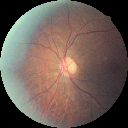

In [ ]:
# Visualize one image
array_to_img(X_train[0])

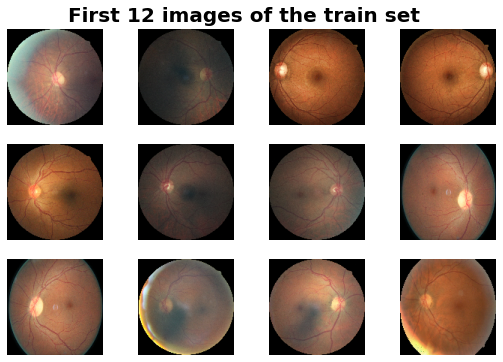

In [ ]:
# Visualize some images
fig = plt.figure(figsize = (9, 6))
columns = 4
rows = 3
for i in range(1, rows*columns + 1):
    img = X_train[i-1].tolist()
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    fig.suptitle('First 12 images of the train set', fontsize = 20, y = .93, weight = 'bold')
    plt.axis('off');

In [ ]:
brightness_values = np.fromiter(map(calculate_brightness,(X_train*255).astype(np.uint8)), dtype=np.int)
df_bright = pd.DataFrame(brightness_values, columns = ['brightness'])
df_bright.describe()

,brightness
count,5000.000000
mean,105.952600
std,38.178128
min,2.000000
25%,78.000000
50%,105.000000
75%,133.000000
max,224.000000


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


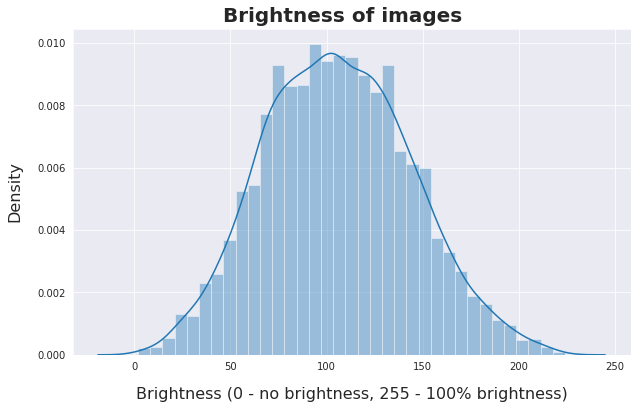

In [ ]:
# Plot distribution
sns.set_style('darkgrid')
fig = plt.figure(figsize = (10, 6))
sns.distplot(df_bright['brightness'])
fig.suptitle('Brightness of images', fontsize = 20, y = .93, weight = 'bold')
plt.xlabel('Brightness (0 - no brightness, 255 - 100% brightness)', size = 16, labelpad = 15)
plt.ylabel('Density', size = 16, labelpad = 15);

**Hereinafter we present 3 best models obtained in 3 experimental settings: transfer learning, ensemble learning and modifying the given sample model**

**Experimental setting 1: Transfer learning**

Load model

In [ ]:
def model_fn(labels_dim,model_name='transfer1',opt_type='sgd'):

    if model_name=='default':
      print('Model name: Default')

      """Create a Keras Sequential model with layers."""
      model = keras.models.Sequential()
      # default model
      model.add(keras.layers.Conv2D(32, kernel_size=(3, 3),
                                  activation='relu',
                                  input_shape=(128, 128,3)))
      model.add(keras.layers.MaxPooling2D((2, 2)))
      model.add(keras.layers.Dropout(0.25))
      model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='glorot_uniform'))
      model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
      model.add(keras.layers.Dropout(0.25))
      model.add(keras.layers.Flatten())
      model.add(keras.layers.Dense(128, activation='relu', kernel_initializer='glorot_uniform'))
      model.add(keras.layers.Dropout(0.5))
      model.add(keras.layers.Dense(labels_dim, activation='softmax', kernel_initializer='glorot_uniform'))
    elif model_name=='extended':
      print('Model name: Extended')

      model = keras.models.Sequential()
      model.add(keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(128, 128, 3)))
      model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
      model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
      model.add(keras.layers.Dropout(0.25))
      
      model.add(keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
      model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
      model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
      model.add(keras.layers.Dropout(0.25))

      model.add(keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
      model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
      model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
      model.add(keras.layers.Dropout(0.25))
      
      model.add(keras.layers.Flatten())
      model.add(keras.layers.Dense(512, activation='relu'))
      model.add(keras.layers.Dropout(0.5))
      model.add(keras.layers.Dense(labels_dim, activation='softmax'))
    elif model_name=='transfer1':
      print('Model name: Transfer')
      base_model = tf.keras.applications.InceptionV3(include_top=False,input_shape=(128, 128,3))

      # add a global spatial average pooling layer
      x = base_model.output
      output = keras.layers.BatchNormalization()(x)
      x = keras.layers.GlobalAveragePooling2D()(x)

      x = keras.layers.Dense(1024, activation='relu')(x)
      
      predictions = keras.layers.Dense(5, activation='softmax')(x)

      model = keras.models.Model(inputs=base_model.input, outputs=predictions)

      # first: train only the top layers, i.e. freeze all convolutional layers
      for layer in base_model.layers:
          layer.trainable = False

      for layer in model.layers:
          layer.trainable = True

    model.summary()

    # which optimizer to use
    if opt_type=='sgd':
      print('Optimizer: SGD')
      opt=keras.optimizers.SGD(lr=1e-2, momentum=0.9, decay=1e-2/25, nesterov=False)
    elif opt_type=='adam':
      print('Optimizer: Adam')
      opt=keras.optimizers.Adam(lr=1e-3, amsgrad=True)
    elif opt_type=='diffgrad':
      print('Optimizer: DiffGrad')
      opt=DiffGrad(lr=0.001)

    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=opt,
                  metrics=['accuracy'])

    return model

Run model

In [ ]:
history, model=run(load_previous_model=False, num_epochs=50,apply_preprocessing=False,job_dir='models/model_5')

Model name: Transfer
87916544/87910968 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 63, 63, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 63, 63, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 63, 63, 32)   0           batch_normalization[0][0]        
________

In [ ]:
latest = get_latest('models/model_5')
model = model_fn(5)
model.load_weights(latest)

Model name: Transfer
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 63, 63, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, 63, 63, 32)   96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 63, 63, 32)   0           batch_normalization_95[0][0]     
_______________________________________________________________________

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

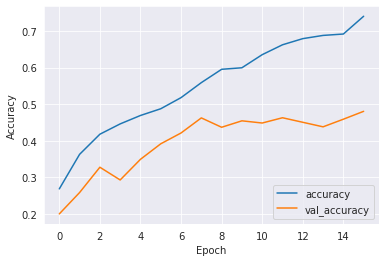

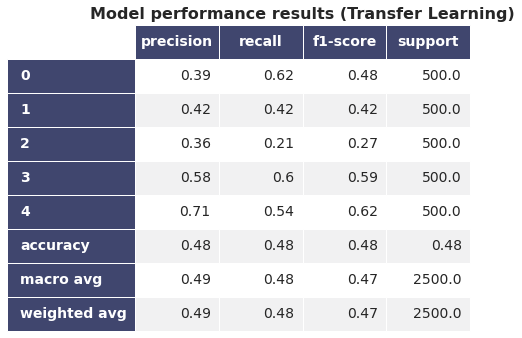

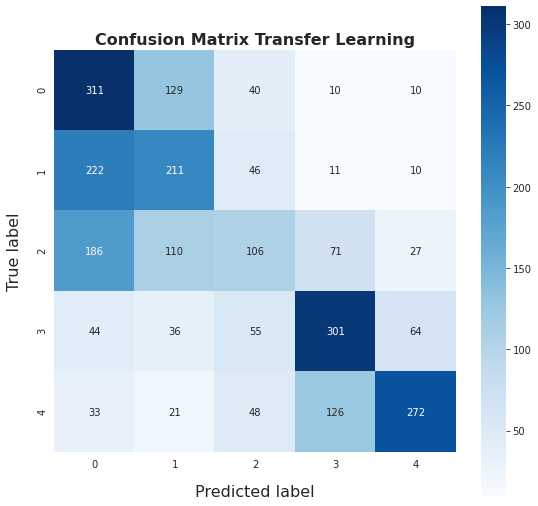

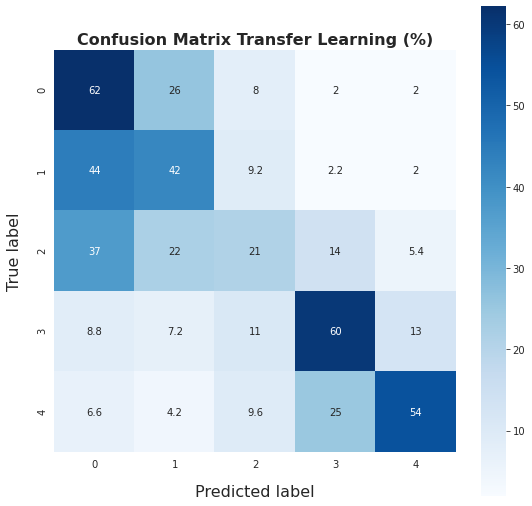

In [ ]:
show_plots(history, model, 'Transfer Learning');

Look at calibration of this model

In [ ]:
# Make predictions
probs = model.predict(X_test)
labels = Y_test

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

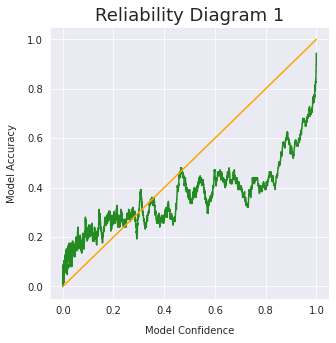

In [ ]:
diagram_1 = reliability_diagram(probs, labels, '1', y_axis='accuracy')

In [ ]:
# Look at calibration errors
true_labels = np.argmax(Y_test, -1)

ece = um.ece(true_labels, probs, num_bins=20) # expected error
sce = um.sce(true_labels, probs, num_bins=20) # static error
ece, sce

(0.21866108992695807, 0.09610743420153144)

**Experimental setting 2: Ensemble learning based on 5 transfer learning models**

In [ ]:
n_members = 4
for i in range( n_members):
   filename = 'models/model_{}'.format(i+1) 
   model=run(load_previous_model=False, num_epochs=50, apply_preprocessing=False, job_dir= filename)

Model name: Transfer
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 63, 63, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 63, 63, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 63, 63, 32)   0           batch_normalization[0][0]        
_________________________________________________________________________

In [ ]:
# Make an ensemble prediction for multi-class classification
from numpy import array
from numpy import argmax
def ensemble_predictions(members, testX):
  # make predictions
  yhats = [model.predict(testX) for model in members]
  yhats = array(yhats)
  # sum across ensemble members
  summed = np.sum(yhats, axis=0)
  sum = summed/5
  sum = sum.round(2)
  # argmax across classes
  result = argmax(summed, axis=1)
  return result, sum

In [ ]:
# Load models from files
def load_all_models(n_models):
  all_models = list()
  for i in range(n_models):
    latest = get_latest('models/model_{}'.format(i+1))
    model = model_fn(5)
    model.load_weights(latest)
    # add to list of members
    all_models.append(model)
    print('>loaded %s' % latest)
  return all_models

# Load models from 5 runs
n_members = 5
members = load_all_models(n_members)

Model name: Transfer
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 63, 63, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, 63, 63, 32)   96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 63, 63, 32)   0           batch_normalization_95[0][0]     
_______________________________________________________________________

In [ ]:
pred_Y, pred_Y_prob = ensemble_predictions(members, X_test)
Y_test_copy = argmax(Y_test, axis=1)

In [ ]:
#evaluation of model
accuracy_score(Y_test_copy, pred_Y)

0.5188

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

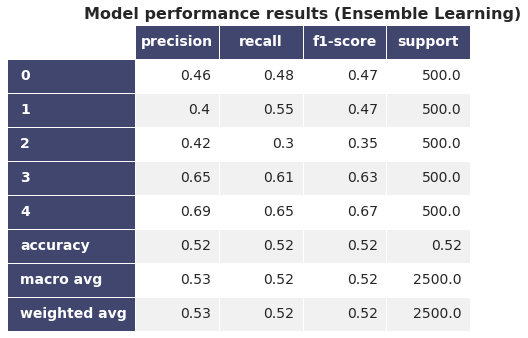

In [ ]:
df_report = pd.DataFrame(classification_report(Y_test_copy, pred_Y, output_dict = True)).transpose()
df_report = df_report.round(2)

table = render_mpl_table(df_report, header_columns = 0, col_width = 1.5)
table.set_title('Model performance results (Ensemble Learning)', size = 16, weight = 'bold', y = 1);
#plt.savefig("report_ensemble.png", bbox_inches = 'tight')
#files.download("report_ensemble.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

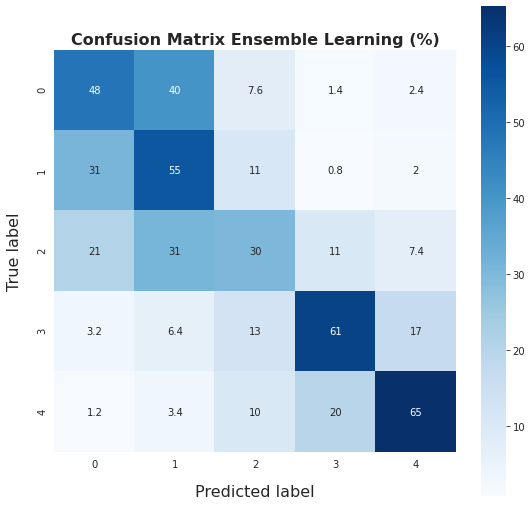

In [ ]:
# Confusion matrix
cm_pred = confusion_matrix(Y_test_copy, pred_Y)
cmn = (cm_pred.astype('float') / cm_pred.sum(axis=1)[:, np.newaxis])*100
  
plt.figure(figsize = (9, 9))
sns.heatmap(cmn, annot = True, xticklabels = (0, 1, 2, 3, 4),
            yticklabels = (0, 1, 2, 3, 4),
            square = True, cmap = "Blues")
plt.xlabel('Predicted label', size = 16, labelpad = 15)
plt.ylabel('True label', size = 16, labelpad = 15)
plt.title("Confusion Matrix Ensemble Learning (%)", fontsize = 16, weight = 'bold');
#plt.savefig("cm_ensemble.png", bbox_inches = 'tight')
#files.download("cm_ensemble.png")

Calibration of this model

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

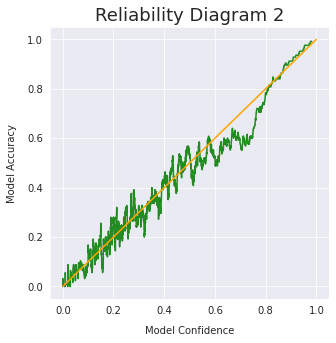

In [ ]:
diagram_2 = reliability_diagram(pred_Y_prob, labels, '2', y_axis='accuracy')

In [ ]:
# Look at calibration errors
true_labels = np.argmax(Y_test, -1)

ece = um.ece(true_labels, pred_Y_prob, num_bins=20) # expected error
sce = um.sce(true_labels, pred_Y_prob, num_bins=20) # static error
ece, sce

(0.03787199789881707, 0.03294254549895574)

In [ ]:
# Clean disc memory
!rm -rf 'models'

**Present results to the user**

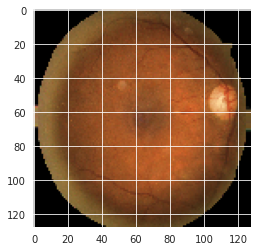

In [ ]:
# Select a random image
from random import randint
image_num = randint(0, 2500)
input_image = X_test[image_num]
plt.imshow(array_to_img(input_image))

In [ ]:
# Make prediction
image_prediction = pred_Y_prob[image_num]
image_class = np.argmax(image_prediction)
print(image_prediction)
print(image_class)

if image_class == 0:
  diagnosis = 'No DR'
elif image_class == 1:
  diagnosis = 'Mild DR'
elif image_class == 2:
  diagnosis = 'Moderate DR'
elif image_class == 3:
  diagnosis = 'Severe DR'
else:
  diagnosis = 'Proliferative DR'
diagnosis

predictions = pd.DataFrame([['Predicted class', image_class], ['Diagnosis', diagnosis],
                            ['Probability of predicted class', round(100*(max(image_prediction)), 2)]])
predictions.set_index(0, inplace = True)
predictions.columns = ['Results']

[0.02 0.01 0.1  0.02 0.86]
4


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

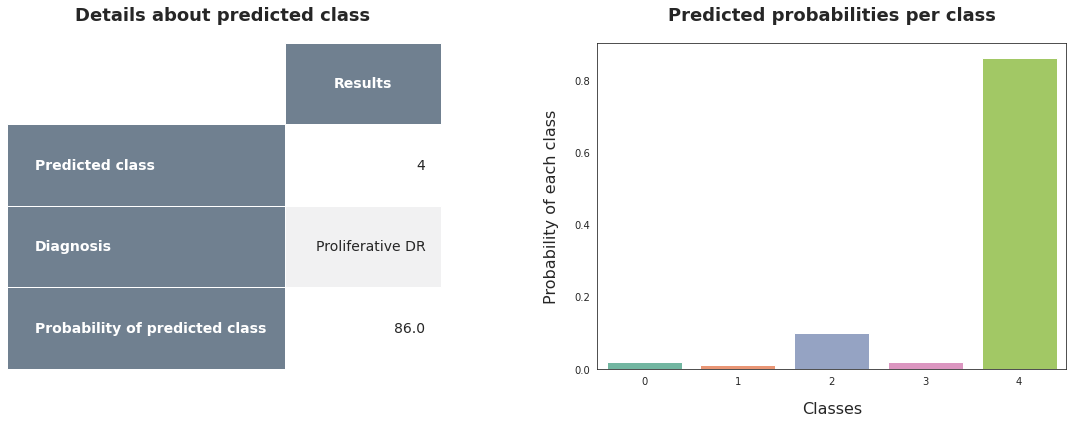

In [ ]:
# Present the results
sns.set_style('white')
sns.set_palette('Set2', n_colors = 5)
fig, ax = plt.subplots(nrows = 1, ncols = 2, squeeze = False, figsize = (14, 6), gridspec_kw={'width_ratios': [1, 3],
                                                                                              'height_ratios': [1]})
sns.barplot(x = [0, 1, 2, 3, 4], y = image_prediction, ax = ax[0, 1])
ax[0, 1].set_title('Predicted probabilities per class',
             size = 18, weight = 'bold', y = 1.05)
ax[0, 1].set_xlabel('Classes', size = 16, labelpad = 15)
ax[0, 1].set_ylabel('Probability of each class', size = 16, labelpad = 15);

render_mpl_table(predictions, header_columns = 0, col_width = 1.3, header_color = 'slategray', ax = ax[0, 0])
ax[0, 0].axis('off')
ax[0, 0].set_title('Details about predicted class',
                   size = 18, weight = 'bold', y = 1.05, x = -0.4)

fig.subplots_adjust(wspace = 0.5);

#fig.savefig("present_results.png", bbox_inches = 'tight')
#files.download("present_results.png")

**Experimental setting 3: Modify provided sample model**

In [ ]:
FILE_PATH = 'cp-{epoch:04d}.h5'
checkpoint_path = FILE_PATH
checkpoint_path = os.path.join('sample_model_setting', checkpoint_path)

# Model checkpoint callback to save only when accuracy improves
checkpoint_1 = keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',
    verbose=2,
    save_best_only = True,
    mode='max')

# Tensorboard logs callback
tblog = keras.callbacks.TensorBoard(
    log_dir=os.path.join('job_dir', 'logs'),
    histogram_freq=0,
    update_freq='epoch',
    write_graph=True,
    embeddings_freq=0)

callback_1 = [checkpoint_1, tblog]

In [ ]:
# Data augmentation
datagen = ImageDataGenerator(
        horizontal_flip=True,
        vertical_flip=True)
# Model parameters
num_epochs=100
batch=64
# To define steps per epoch when use data generator
steps_epoch = ceil(5000/batch) # size of training set / batch size
# Add Early Stopping, stop when validation accuracy isn't improving anymore
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                            verbose = 2, patience = 8)

In [ ]:
def model_fn_1(labels_dim):
    """Create a Keras Sequential model with layers."""
    
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(32, kernel_size=(3, 3),
                                  activation='relu',
                                  input_shape=(128, 128, 3)))
    model.add(keras.layers.MaxPooling2D((2, 2)))
    model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='glorot_uniform',
                                  kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    model.add(keras.layers.MaxPooling2D((2, 2)))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(512, activation='relu', kernel_initializer='glorot_uniform'))
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(labels_dim, activation='softmax',
                                 kernel_initializer='glorot_uniform'))
    model.summary()
    compile_model(model)      

    return model

# Specify the loss function and optimizer to use for the model
def compile_model(model):
    opt = keras.optimizers.Adam(lr=0.001, amsgrad=True)
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=opt,
                  metrics=['accuracy'])
    return model

CLASS_SIZE = 5
retinopathy_model = model_fn_1(CLASS_SIZE)

history = retinopathy_model.fit(
              datagen.flow(X_train, Y_train, batch_size = batch), # apply data augmentation
              steps_per_epoch = steps_epoch, # number of batches of samples comprising one epoch
              epochs = num_epochs,
              callbacks = [early_stopping, callback_1],
              verbose = 2,
              validation_data = (X_test, Y_test))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_564 (Conv2D)          (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_565 (Conv2D)          (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 57600)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 512)               29491712  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0

In [ ]:
latest = get_latest('sample_model_setting')
model_sample = model_fn_1(5)
model_sample.load_weights(latest)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_566 (Conv2D)          (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_567 (Conv2D)          (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 57600)             0         
_________________________________________________________________
dense_14 (Dense)             (None, 512)               29491712  
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)              

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

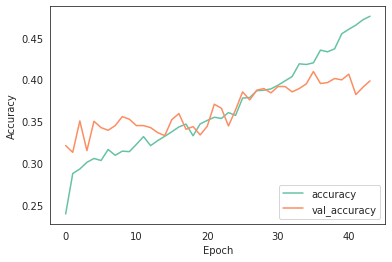

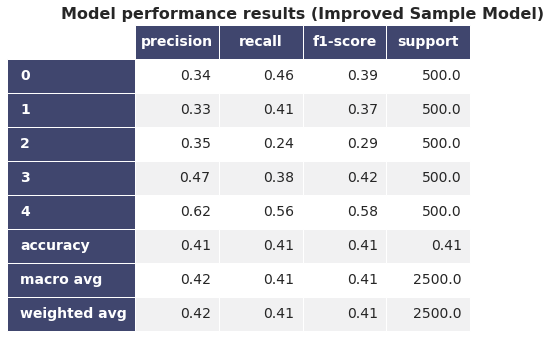

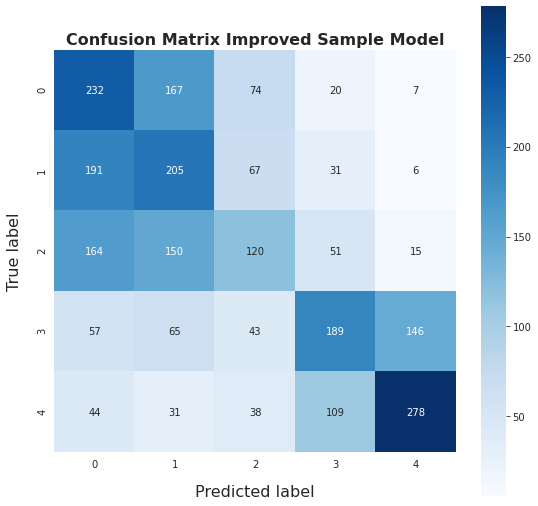

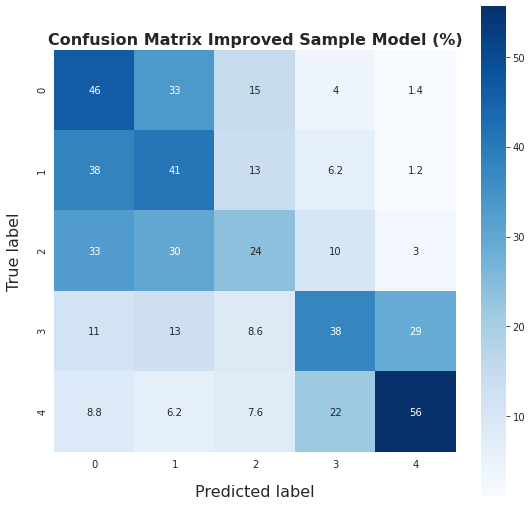

In [ ]:
show_plots(history, model_sample, name = 'Improved Sample Model');

In [ ]:
# Remove directory with saved models to clean Disc
!rm -rf 'sample_model_setting'

Look at calibration of this model

In [ ]:
# Make predictions
probs = model_sample.predict(X_test)
labels = Y_test

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

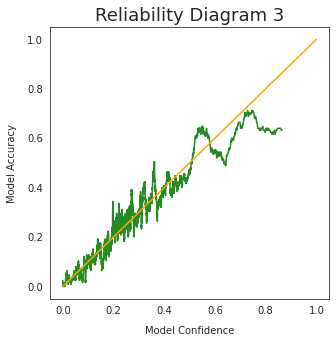

In [ ]:
diagram_2 = reliability_diagram(probs, labels, '3', y_axis='accuracy')

In [ ]:
# Look at calibration errors
true_labels = np.argmax(Y_test, -1)

ece = um.ece(true_labels, probs, num_bins=20) # expected error
sce = um.sce(true_labels, probs, num_bins=20) # static error
ece, sce

(0.04710140955448152, 0.02594221685979628)